# Methods

In this notebook, I will be walking through how we can estimate different methods based on the density cubes that we derive.

In [5]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

import pathlib

# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# 
# Experiment Functions
from src.data.esdc import get_dataset
from src.features import Metrics
from src.features.temporal import select_period, get_smoke_test_time, TimePeriod
from src.features.spatial import select_region, get_europe, get_spain
from src.models.train_models import get_similarity_scores
from src.experiments.utils import dict_product, run_parallel_step

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.models.similarity import cka_coefficient, rv_coefficient, rbig_it_measures

# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr

from tqdm import tqdm

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Get DataCubes

In [6]:
!ls /media/disk/databases/ESDC/

Cube_2019highColombiaCube_184x120x120.zarr
Cube_2019highColombiaCube_1x3360x2760.zarr
esdc-8d-0.083deg-184x270x270-2.0.0.zarr
esdc-8d-0.083deg-1x2160x4320-2.0.0.zarr
esdc-8d-0.25deg-184x90x90-2.0.0.zarr
esdc-8d-0.25deg-1x720x1440-2.0.0.zarr


In [7]:
esdc = get_dataset(['gross_primary_productivity'])
esdc

,Array,Chunk
Bytes,7.06 GB,4.15 MB
Shape,"(1702, 720, 1440)","(1, 720, 1440)"
Count,1703 Tasks,1702 Chunks
Type,float32,numpy.ndarray


## 2. Select Region

In [8]:
from src.features.spatial import get_europe, get_spain, select_region
# from src.features.spatial import 
# subset with bounding box
datacube = select_region(esdc, bbox=get_europe())

## 2. Remove Climatology

In [11]:
from src.features.temporal import remove_climatology

# remove the climatology
datacube_ = remove_climatology(datacube)

## 3. Resample - Mean Values per Month

In [26]:
datacube__ = datacube.resample(time='1MS').mean()
datacube__

,Array,Chunk
Bytes,59.33 MB,133.63 kB
Shape,"(444, 144, 232)","(1, 144, 232)"
Count,8141 Tasks,444 Chunks
Type,float32,numpy.ndarray


## 2. Select Region

For this task, we are going to do something simple: work with only Europe and a segment of Eurasia. I have outlined a region described the latitude and longitude coordintes. With these coordinates, we can subset a section of the cube and continue working with that region only.

In [27]:
from src.features.temporal import select_period
from src.features.spatial import select_region

In [28]:
# get european bounding box
europe_bbox = get_europe()
time_period = ('July-2010', 'July-2010')

# subset region
europe_datacube = subset_cube(datacube, europe_bbox)

# subset region
europe_datacube_201007 = select_period(europe_datacube, time_period)

europe_datacube_201007

NameError: name 'subset_cube' is not defined

/home/emmanuel/.conda/envs/rbig_eo/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


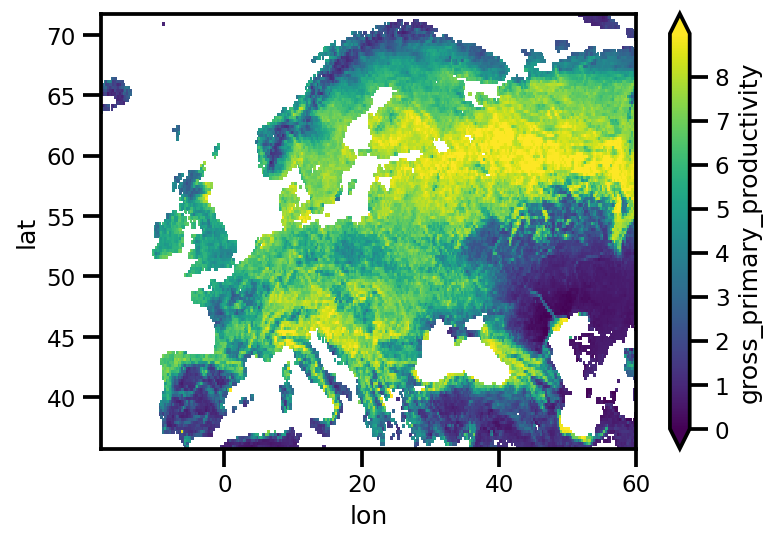

In [9]:
europe_datacube_201007.gross_primary_productivity.mean('time').plot(vmin=0, robust=True)

## 3. Get Density Cubes

Now, we are going to create some density cubes. Instead of just taking the entire amount of samples, we are going to actually construct features. These features will be the neighbouring pixels in a spatial-temporal manner. For this demonstration, we will assume that the pixels

In [10]:
from src.features.preprocessing import DensityCubes

In [17]:
def get_density_cubes(data: xr.Dataset, spatial: int, temporal: int) -> Tuple[str, pd.DataFrame]:
    """Wrapper Function to get density cubes from a dataarray"""
    for ikey, idata in data.items():
        yield ikey, DensityCubes(
            spatial_window=spatial,
            time_window=temporal
        ).get_minicubes(idata)

In [18]:
# All samples
europe_df = europe_datacube_201007.to_dataframe().dropna()

# reorder index
levels = ['time', 'lon', 'lat']
europe_df = europe_df.reorder_levels(levels)

# europe_df = europe_df[indx]
europe_df.head()

,,,gross_primary_productivity
time,lon,lat,
2010-07-08,51.625,71.625,1.747494
2010-07-16,51.625,71.625,1.073725
2010-07-24,51.625,71.625,1.334421
2010-07-08,51.875,71.625,1.201953
2010-07-16,51.875,71.625,0.647814


In [22]:
spatial = 1
temporal = 3

ivar, europe_temp_df = next(get_density_cubes(
    europe_datacube_201007,
    spatial=spatial,
    temporal=temporal
))

levels = ['time', 'lon', 'lat']
europe_temp_df = europe_temp_df.reorder_levels(levels)

europe_temp_df.head()

var_x0    var_x1    var_x2
time       lon    lat                                 
2010-07-24 51.625 71.625  1.747494  1.073725  1.334421
           51.875 71.625  1.201953  0.647814  0.841013
           52.125 71.625  1.158344  0.755085  0.847133
           52.375 71.625  1.320013  0.837758  0.829512
           52.625 71.625  1.087877  0.642634  0.499693

In [14]:
levels = ['time', 'lon', 'lat']


idx = europe_temp_df.index.intersection(europe_df.index)


In [15]:
idx.shape, 

((26694,),)

In [16]:
X_df = europe_df.loc[idx,:]
Y_df = europe_temp_df.loc[idx,:]
X_df.shape, Y_df.shape

((26694, 1), (26694, 3))

## 4.1 Models Framework

### 4.1 Preprocessing

#### 4.1.1 - Training and testing

In [17]:
europe_df.head()


,,,gross_primary_productivity
time,lon,lat,
2010-07-08,51.625,71.625,1.747494
2010-07-16,51.625,71.625,1.073725
2010-07-24,51.625,71.625,1.334421
2010-07-08,51.875,71.625,1.201953
2010-07-16,51.875,71.625,0.647814


In [18]:
y = europe_df.iloc[:, 0][:, np.newaxis]
X = europe_df.iloc[:, 1:]

d_dimensions = X.shape[1]

#### 4.1.2 - Train-Test Split

In [48]:
from sklearn.model_selection import train_test_split


train_size = 2_000
random_state = 123

xtrain, xtest, ytrain, ytest = train_test_split(
    X, y, train_size=train_size, random_state=random_state)

test_size = xtest.shape[0]

#### 4.1.1 - Normalize

In [49]:
from sklearn.preprocessing import StandardScaler

# normalize inputs
x_normalizer = StandardScaler(with_mean=True, with_std=False)

xtrain_norm = x_normalizer.fit_transform(xtrain)
xtest_norm = x_normalizer.transform(xtest)

# remove mean outputs
y_normalizer = StandardScaler(with_std=False)

ytrain_norm = y_normalizer.fit_transform(ytrain)
ytest_norm = y_normalizer.transform(ytest)

### 4.2 - Training

In [50]:
# from src.models.gp import SparseGPR
import GPy
from scipy.cluster.vq import kmeans2

In [76]:
# Kernel Function (RBF)
n_dims = xtrain_norm.shape[1]
kernel = GPy.kern.RBF(input_dim=n_dims, ARD=False)

# Inducing Points
n_inducing = 100
z = kmeans2(X, n_inducing, minit="points")[0]

# Initialize GP Model
gp_model = GPy.models.SparseGPRegression(X, y, kernel=kernel, Z=z)

# choose VFE inference method
gp_model.inference_method = (GPy.inference.latent_function_inference.VarDTC())

# fix variance to be low in the beginning
gp_model.Gaussian_noise.variance = 0.01

2020-04-30 19:40:34,207:INFO:initializing Y
2020-04-30 19:40:34,209:INFO:initializing inference method
2020-04-30 19:40:34,209:INFO:adding kernel and likelihood as parameters
2020-04-30 19:40:34,211:INFO:Adding Z as parameter


In [77]:
# optimize GP Model
n_restarts = 0
verbose = 1
max_iters = 1_000

# optimize
gp_model.optimize(
    optimizer='scg',
    messages=verbose,
    max_iters=max_iters,
);

TypeError: unsupported format string passed to NoneType.__format__

### 4.3 - Testing

In [78]:
ypred = gp_model.predict(xtest_norm, )[0]

In [79]:
ypred.shape, ytest_norm.shape

((67414, 1), (67414, 1))

In [80]:
stats = Metrics().get_all(ypred.squeeze(), ytest_norm.squeeze())
stats

,mae,mse,rmse,r2
0,1.584058,4.35029,2.085735,0.325761


In [81]:
def _predict(model, Xs, batch_size):
    ms = []
    n = max(len(Xs) / batch_size, 1)  # predict in small batches
    with tqdm(np.array_split(Xs, n)) as bar:
        for xs in bar:
            m = model.predict(xs,)
            ms.append(m)

    return np.vstack(ms)

In [85]:
batch_size = 5_000
ms = []
n = max(len(xtest_norm) / batch_size, 1)  # predict in small batches
with tqdm(np.array_split(xtest_norm, n)) as bar:
    for xs in bar:
        m = sgp_model.predict(xs,)
        ms.append(m)



100%|██████████| 598/598 [00:51<00:00, 11.56it/s]


## 5. Direct Measurements

### 5.1 - $\rho$V Coefficient

Now, we will explore the easiest linear method. It is the multi-dimensional version of the Pearson Correlation coefficient called the $\rho$V-Coefficient ($\rho$-Vector Coefficient). Most people are familiar with the correlation coefficient:

$$
\rho(X,Y) = \frac{\text{Cov}(X,Y)}{\sqrt{\text{Var}(X)}\sqrt{\text{Var}(Y)}}
$$


This is very well-known in the literature but it doesn't directly apply to multi-dimensional data. The final result of the numerator and the denominator is a scalar value per dimension. There is no way we can summarize all of the information into a single scalar. One extension we can do is to create a matrix with the pairwise components (i.e gram matrices) for each of the variables and then take the Frobenius norm (Hilbert-Schmidt norm) of the cross term as well as the individual terms. So the equation is like so:

$$
\rho V (\mathbf{X,Y}) = 
\frac{\left\langle \mathbf{XX^\top, YY^\top} \right\rangle_\mathbf{F}}
{\sqrt{\left\langle \mathbf{XX^\top} \right\rangle_\mathbf{F}}
\sqrt{\left\langle \mathbf{YY^\top} \right\rangle_\mathbf{F}}}
$$

**Note**: This is very similar to HSIC and Centered Kernel Alignment (CKA) but this method dates back before. CKA generalizes this method with the addition of distance measures and non-linear kernel functions. We will explore this in the next section.

To code this up, we will all of the components of this equation because we will need them later.

In [19]:
from typing import Dict
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics.pairwise import linear_kernel


def rv_coefficient(X: np.ndarray, Y: np.ndarray) -> Dict:
    """simple function to calculate the rv coefficient"""
    # calculate the kernel matrices
    X_gram = linear_kernel(X)
    Y_gram = linear_kernel(Y)
    
    # center the kernels
    X_gram = KernelCenterer().fit_transform(X_gram)
    Y_gram = KernelCenterer().fit_transform(Y_gram)
    
    # normalizing coefficients (denomenator)
    x_norm = np.linalg.norm(X_gram)
    y_norm = np.linalg.norm(Y_gram)
    
    # frobenius norm of the cross terms (numerator)
    xy_norm = np.sum(X_gram * Y_gram)
    
    # rv coefficient
    pv_coeff = xy_norm / x_norm / y_norm
    
    return {
        'coefficient': pv_coeff,
        'x_norm': x_norm,
        'y_norm': y_norm,
        'xy_norm': xy_norm
    }

In [21]:
X_samples = europe_temp_df.iloc[:, 0][:, np.newaxis]
Y_samples = europe_temp_df

logging.info(f" Size of X_samples: {X_samples.shape}, {Y_samples.shape}")

d_dimensions = X.shape[1]

2020-04-30 21:10:39,726:INFO: Size of X_samples: (26694, 1), (26694, 3)


In [22]:
# check that the coefficient is 1 if the data is the same
rv_coeff = rv_coefficient(X_samples[:100], X_samples[:100])
np.testing.assert_almost_equal(rv_coeff['coefficient'], 1)


So now, let's try when we have some a difference between the variables.

In [23]:
%%time 
rv_coeff = rv_coefficient(X_samples[:], Y_samples[:])
rv_coeff

CPU times: user 23.8 s, sys: 4.9 s, total: 28.7 s
Wall time: 13.3 s


{'coefficient': 0.9696304,
 'x_norm': 191155.58,
 'y_norm': 510949.53,
 'xy_norm': 94704630000.0}

### 5.2 - Non-Linear Kernel

An addition that we can do is to explore how the 

In [24]:
from typing import Optional
from scipy.spatial.distance import pdist, squareform

def estimate_sigma(
    X: np.ndarray, 
    method: str='median', 
    percent: Optional[int]=None, 
    heuristic: bool=False
) -> float:

    # get the squared euclidean distances
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    elif percent is not None:
        kth_sample = int((percent/100) * X.shape[0])
        dists = np.sort(squareform(pdist(X, 'sqeuclidean')))[:, kth_sample]
#         print(dists.shape, dists.min(), dists.max())
    else:
        dists = np.sort(pdist(X, 'sqeuclidean'))
#         print(dists.shape, dists.min(), dists.max())


    if method == 'median':
        sigma = np.median(dists)
    elif method == 'mean':
        sigma = np.mean(dists)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")

    if heuristic:
        sigma = np.sqrt(sigma / 2)
    return sigma

In [25]:
from typing import Dict
from sklearn.preprocessing import KernelCenterer
from sklearn.gaussian_process.kernels import RBF


def cka_coefficient(X: np.ndarray, Y: np.ndarray) -> Dict:
    """simple function to calculate the rv coefficient"""
    
    # estimate sigmas
    sigma_X = estimate_sigma(X, method='median', percent=50)
    sigma_Y = estimate_sigma(Y, method='median', percent=50)
    # calculate the kernel matrices
    X_gram = RBF(sigma_X)(X)
    Y_gram = RBF(sigma_Y)(Y)
    
    # center the kernels
    X_gram = KernelCenterer().fit_transform(X_gram)
    Y_gram = KernelCenterer().fit_transform(Y_gram)
    
    # normalizing coefficients (denomenator)
    x_norm = np.linalg.norm(X_gram)
    y_norm = np.linalg.norm(Y_gram)
    
    # frobenius norm of the cross terms (numerator)
    xy_norm = np.sum(X_gram * Y_gram)
    
    # rv coefficient
    pv_coeff = xy_norm / x_norm / y_norm
    
    return {
        'coefficient': pv_coeff,
        'x_norm': x_norm,
        'y_norm': y_norm,
        'xy_norm': xy_norm
    }

In [26]:
# check that the coefficient is 1 if the data is the same
cka_coeff = cka_coefficient(X_samples[:100], X_samples[:100])
np.testing.assert_almost_equal(cka_coeff['coefficient'], 1)


In [27]:
%%time 
cka_coeff = cka_coefficient(X_samples[:10_000], Y_samples[:10_000])
cka_coeff

CPU times: user 20.4 s, sys: 2.89 s, total: 23.3 s
Wall time: 17 s


{'coefficient': 0.9576703788185938,
 'x_norm': 2326.331280441253,
 'y_norm': 1175.2587321221124,
 'xy_norm': 2618310.2249249523}

### Variation of Information

In [28]:
from rbig.rbig import RBIGMI, RBIG

rbig_results = {}

In [29]:
def variation_of_info(H_X, H_Y, I_XY):
    return I_XY / np.sqrt(H_X) / np.sqrt(H_Y)

In [30]:
%%time 
n_layers = 10000
rotation_type = 'PCA'
random_state = 0
zero_tolerance = 60
pdf_extension = None
pdf_resolution = None
tolerance = None

# Initialize RBIG class
H_rbig_model = RBIG(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
rbig_results['H_x'] = H_rbig_model.fit(X_samples).entropy(correction=True);

rbig_results['H_y'] = H_rbig_model.fit(Y_samples).entropy(correction=True);

# Initialize RBIG class
I_rbig_model = RBIGMI(n_layers=n_layers, 
                  rotation_type=rotation_type, 
                  random_state=random_state, 
                  zero_tolerance=zero_tolerance,
                  tolerance=tolerance)

# fit model to the data
rbig_results['I_xy'] = I_rbig_model.fit(X_samples, Y_samples).mutual_information();

# calculate the variation of information coefficient
rbig_results['coefficient'] = variation_of_info(
    rbig_results['H_x'],
    rbig_results['H_y'],
    rbig_results['I_xy']
)

CPU times: user 4min 12s, sys: 36.4 s, total: 4min 49s
Wall time: 11.2 s


In [210]:
rbig_results

{'H_x': 3.2281169474002924,
 'H_y': 5.181635094706355,
 'I_xy': 5.412206453196236,
 'coefficient': 1.3233243751128443}